# Test Semi-Supervised Hyperspectral Image Classification via Spatial-Regulated Self-Training

1. Import dependencies

In [1]:
import random
import torch
import numpy as np

from IPython.display import HTML

from torch import nn
from torch import optim

from src.util.torch_device import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.trainer.spatial_regulated_self_trainer import SpatialRegulatedSelfTrainer
from src.trainer.spatial_regulated_self_trainer import SpatialRegulatedSelfTrainerArgs
from src.model.hyperspectral_cnn import FullyConvolutionalNetworks
from src.util.semi_guided import sample_from_segmentation_matrix
from src.visualization.plot import plot_segmentation_comparison
from src.visualization.plot import (
    plot_loss,
    plot_f1_score,
    plot_accuracy,
    plot_progress_animation,
)

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [3]:
f"Device is {device}"

'Device is mps'

# Indian pines

0. Set params

In [4]:
splits = 4
learning_rate = 1e-3
patch_size = 9
num_epochs = 12
examples_per_class = 10

1. Load dataset

In [5]:
image, labels = load_indian_pines()

In [6]:
masked_labels = sample_from_segmentation_matrix(labels, examples_per_class)

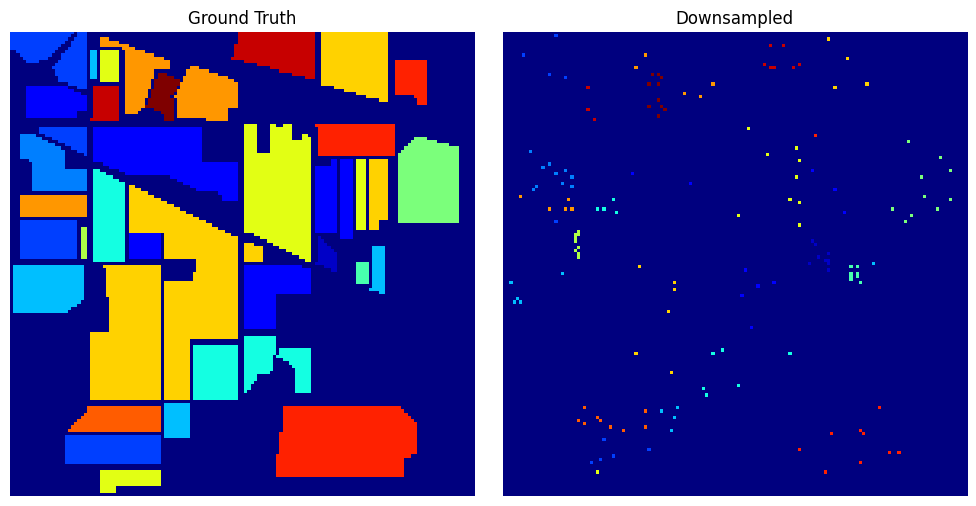

In [7]:
plot_segmentation_comparison(labels, masked_labels, title2="Downsampled")

In [8]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

2. Train model

In [9]:
input_channels = int(image.shape[-1] / splits)
model = FullyConvolutionalNetworks(input_channels, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

args = SpatialRegulatedSelfTrainerArgs(
    model=model,
    optimizer=optimizer,
    num_classes=num_classes,
    over_cluster_count=num_classes * 2,
    over_cluster_count_decay=5,
    loss_fun=nn.CrossEntropyLoss(),
    num_epochs=num_epochs,
    splits=splits,
    patch_size=patch_size,
    init_patch_size=4,
    semantic_threshold=0.5,
    spatial_threshold=8,
    spatial_constraint_weights=[1, 0.5],
)

trainer = SpatialRegulatedSelfTrainer(args, device)

In [10]:
y = trainer.train(image, masked_labels, labels)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

3. Training results

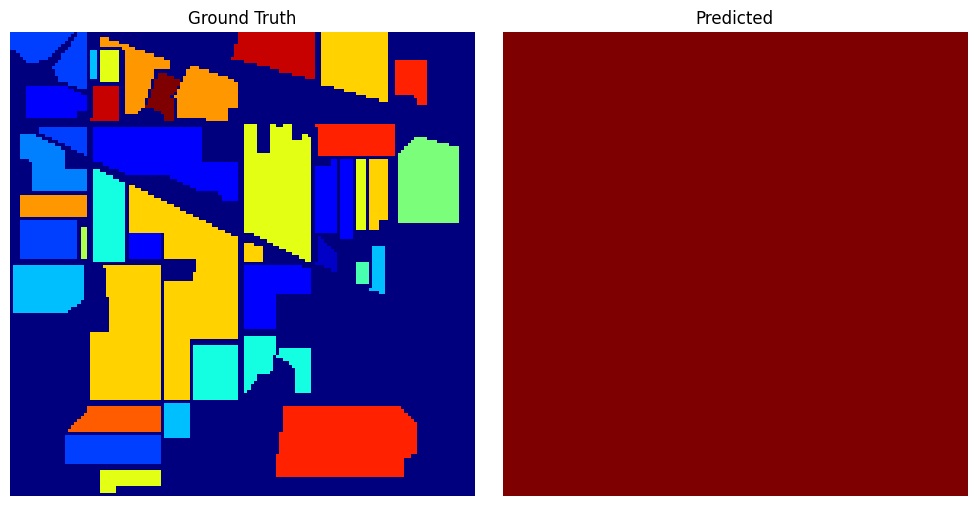

In [11]:
plot_segmentation_comparison(labels, y)

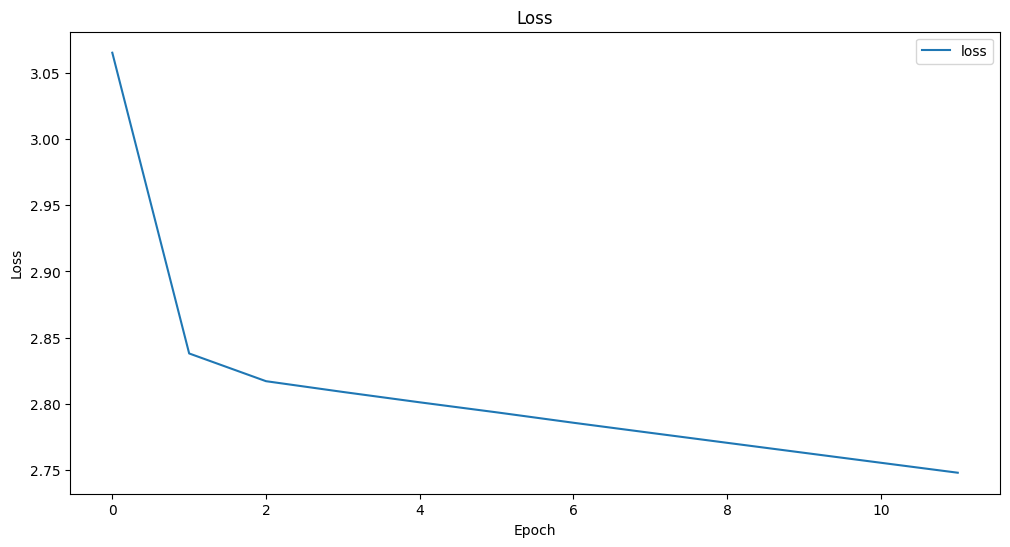

In [12]:
plot_loss(trainer.history)

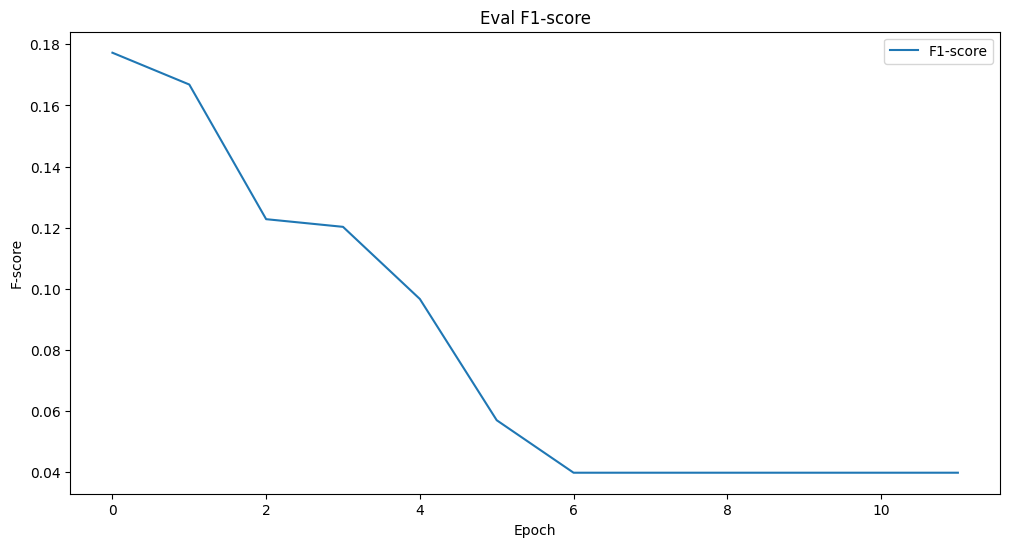

In [13]:
plot_f1_score(trainer.history)

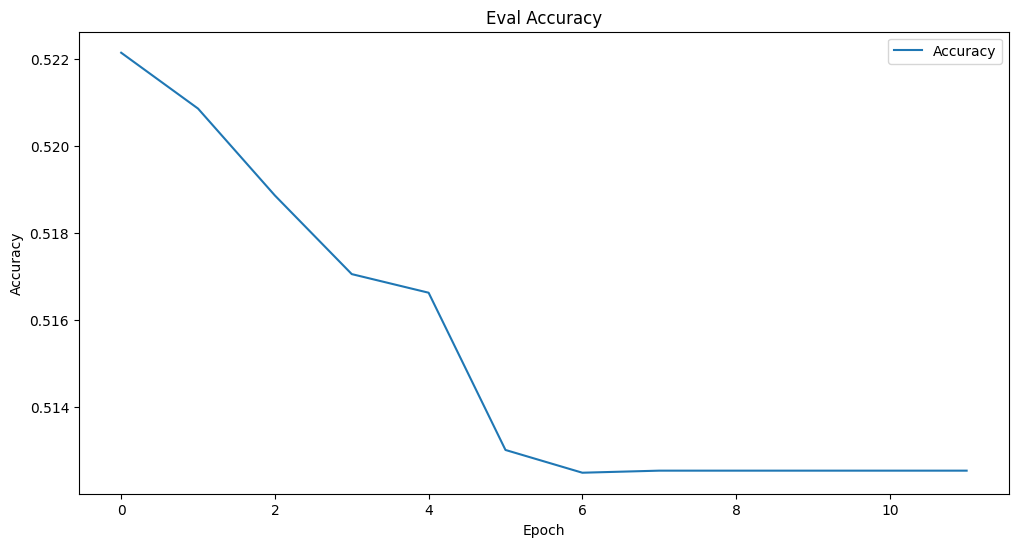

In [14]:
plot_accuracy(trainer.history)

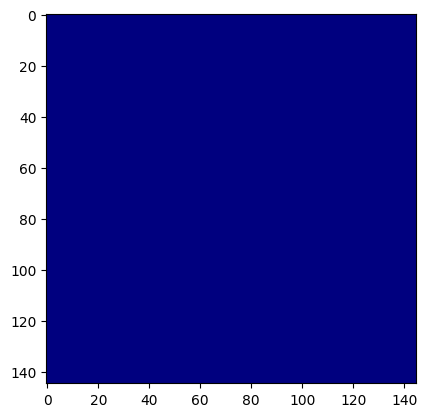

In [15]:
ani = plot_progress_animation(trainer.pred_attempts)

HTML(ani.to_jshtml())